<a href="https://colab.research.google.com/github/Yevheniia-Ilchenko/ML_DS_tasks/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

url = "https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=sample_submission.csv"
od.download(url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: evheniiailchenko
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 111MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


Area under ROC score on Train dataset: 0.77%


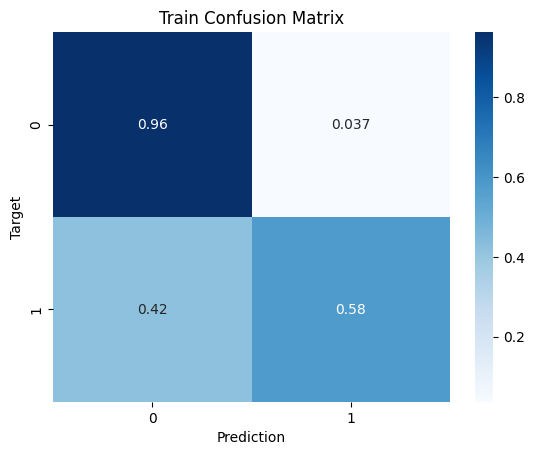

Area under ROC score on Validation dataset: 0.75%


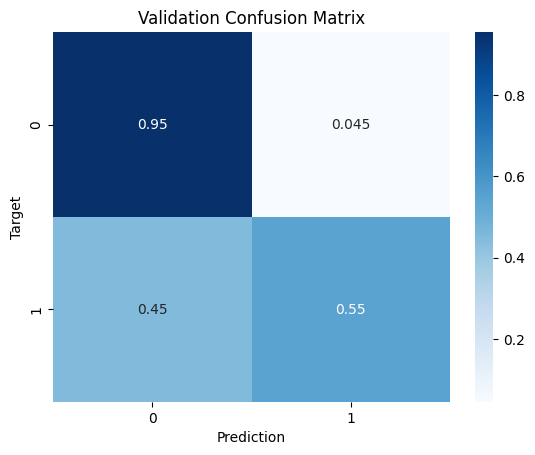

['bank_customer_pipline.joblib']

In [ ]:

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



raw_df = pd.read_csv("/content/bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

train_df, val_df = train_test_split(raw_df, test_size = 0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, "Train")
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline,"bank_customer_pipline.joblib")


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.79%


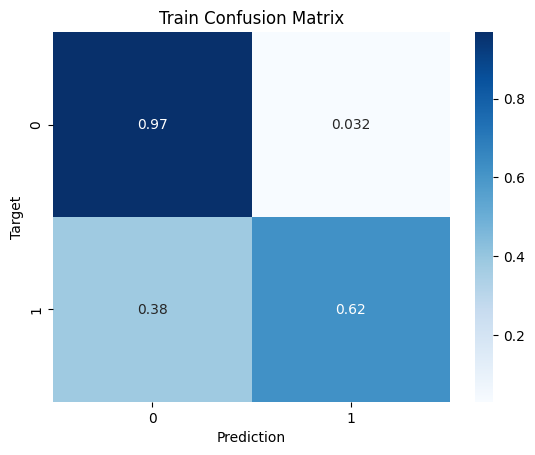

Area under ROC score on Validation dataset: 0.77%


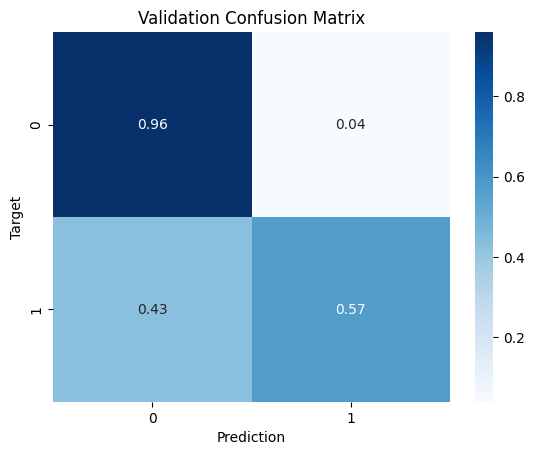

['bank_customer_pipline.joblib']

In [ ]:
from sklearn.preprocessing import PolynomialFeatures


raw_df = pd.read_csv("/content/bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

train_df, val_df = train_test_split(raw_df, test_size = 0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ("polynom", PolynomialFeatures(degree = 2)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, "Train")
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline,"bank_customer_pipline.joblib")

Ця модель краще генералізує і на тренувальних і на тествоих даних

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.83%


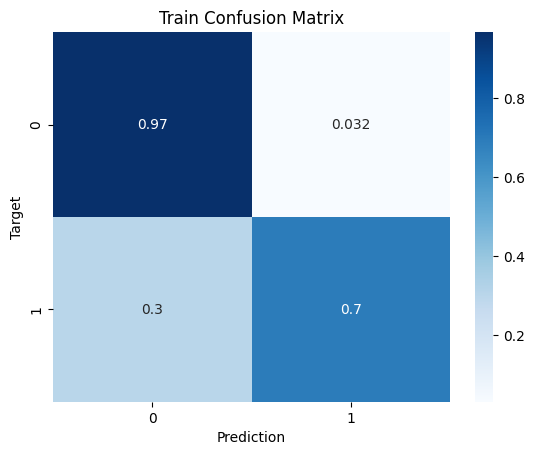

Area under ROC score on Validation dataset: 0.79%


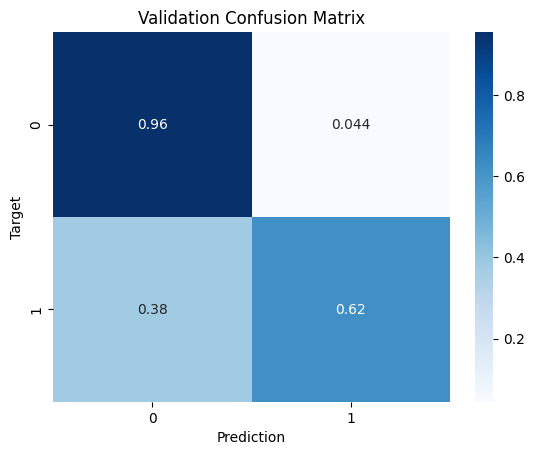

['bank_customer_pipline.joblib']

In [ ]:
raw_df = pd.read_csv("/content/bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

train_df, val_df = train_test_split(raw_df, test_size = 0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ("polynom", PolynomialFeatures(degree = 4)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, "Train")
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline,"bank_customer_pipline.joblib")

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Пробую використати різні варіанти Pipelines

In [ ]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('poly', PolynomialFeatures(degree=5, include_bias=False)),
            ('scaler', MinMaxScaler())
        ]), inputs_cols)
    ])
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor ),
    ("lin_reg", LinearRegression())
])

model_pipeline.fit(train_input, train_target)
preds_train = model_pipeline.predict(train_input)
preds_test = model_pipeline.predict(test_input)

rmse_train = np.sqrt(mean_squared_error(train_target, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_target, preds_test))

train_r2 = r2_score(train_target, preds_train)
test_r2 = r2_score(test_target, preds_test)

print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')


Training RMSE: 1.498012525636353e-13
Test RMSE: 12.363286870575426
Training R^2: 1.0
Test R^2: 0.9344849674479442


In [ ]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]

model_pipeline = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("scaler", MinMaxScaler()),
    ("lin_reg", LinearRegression())
])

model_pipeline.fit(train_input, train_target)
preds_train = model_pipeline.predict(train_input)
preds_test = model_pipeline.predict(test_input)

rmse_train = np.sqrt(mean_squared_error(train_target, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_target, preds_test))

train_r2 = r2_score(train_target, preds_train)
test_r2 = r2_score(test_target, preds_test)

print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Training RMSE: 1.498012525636353e-13
Test RMSE: 12.363286870575426
Training R^2: 1.0
Test R^2: 0.9344849674479442


Пробую використати різні варіанти Pipelines

In [ ]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]

numeric_cols = train_input.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
    ])

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lin_reg", LinearRegression())
])

model_pipeline.fit(train_input, train_target)
preds_train = model_pipeline.predict(train_input)
preds_test = model_pipeline.predict(test_input)

rmse_train = np.sqrt(mean_squared_error(train_target, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_target, preds_test))

train_r2 = r2_score(train_target, preds_train)
test_r2 = r2_score(test_target, preds_test)

print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Training RMSE: 1.498012525636353e-13
Test RMSE: 12.363286870575426
Training R^2: 1.0
Test R^2: 0.9344849674479442


In [ ]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]

preproc = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("scaler", MinMaxScaler())
])
model_pipeline = Pipeline(steps=[
    ("preproc", preproc),
    ("lin_reg", LinearRegression())
])

model_pipeline.fit(train_input, train_target)
preds_train = model_pipeline.predict(train_input)
preds_test = model_pipeline.predict(test_input)

rmse_train = np.sqrt(mean_squared_error(train_target, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_target, preds_test))

train_r2 = r2_score(train_target, preds_train)
test_r2 = r2_score(test_target, preds_test)

print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Training RMSE: 1.498012525636353e-13
Test RMSE: 12.363286870575426
Training R^2: 1.0
Test R^2: 0.9344849674479442


Ще раз прописала вручну **без Pipeline** щоб звірити результат

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]


In [4]:
poly_features = PolynomialFeatures(degree=5, include_bias=False)

train_input_poly = poly_features.fit_transform(train_input)
test_input_poly = poly_features.transform(test_input)

scaler = MinMaxScaler()
train_input = scaler.fit_transform(train_input_poly)
test_input = scaler.transform(test_input_poly)

model = LinearRegression()

pred = model.fit(train_input, train_target)
preds_train = model.predict(train_input)
preds_test = model.predict(test_input)

rmse_train = np.sqrt(mean_squared_error(train_target, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_target, preds_test))

train_r2 = r2_score(train_target, preds_train)
test_r2 = r2_score(test_target, preds_test)

print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Training RMSE: 1.498012525636353e-13
Test RMSE: 12.363286870575426
Training R^2: 1.0
Test R^2: 0.9344849674479442


Бачимо що модель погано генералізує на тестових даних і гарно на тренувальних, що є ознакою перетренування

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

Варіант як в лекції

In [18]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet()
]

In [49]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
inputs_cols = list(train_df.columns)[0:-1]
target_col ="target"

train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
train_target, test_target = train_df[target_col], test_df[target_col]

In [23]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(6)
    val_metrics = np.sqrt(mean_squared_error(y_val, y_val_pred)).round(6)

    return dict(train=train_metrics, val=val_metrics)


In [44]:
poly_features = PolynomialFeatures(degree=20, include_bias=False)
train_input_poly = poly_features.fit_transform(train_input)
test_input_poly = poly_features.transform(test_input)

scaler = MinMaxScaler()
train_input = scaler.fit_transform(train_input_poly)
test_input = scaler.transform(test_input_poly)

In [28]:
train_input_poly.shape, test_input_poly.shape

((103, 53130), (26, 53130))

In [47]:
for model in models:
    model.fit(train_input, train_target)
    eval_results  = evaluate_model(model, train_input, train_target, test_input, test_target)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.0, 'val': 15.674311}

Ridge(): {'train': 8.59775, 'val': 76.562708}

Ridge(alpha=2): {'train': 12.406284, 'val': 94.079153}

Lasso(): {'train': 5.098171, 'val': 5.671931}

ElasticNet(): {'train': 34.179765, 'val': 116.029707}



Варіант однією функцією

In [25]:
raw_reg_df = pd.read_csv("/content/regression_data.csv")

def prepare_model(models):

  train_df, test_df = train_test_split(raw_reg_df, test_size=0.2, random_state=42)
  inputs_cols = list(train_df.columns)[0:-1]
  target_col ="target"

  train_input, test_input = train_df[inputs_cols], test_df[inputs_cols]
  train_target, test_target = train_df[target_col], test_df[target_col]

  poly_features = PolynomialFeatures(degree=20, include_bias=False)
  train_input_poly = poly_features.fit_transform(train_input)
  test_input_poly = poly_features.transform(test_input)

  scaler = MinMaxScaler()
  train_input = scaler.fit_transform(train_input_poly)
  test_input = scaler.transform(test_input_poly)

  model_results = {}

  for model in models:
    model.fit(train_input, train_target)
    y_train_pred = model.predict(train_input)
    y_val_pred = model.predict(test_input)

    train_metrics = np.sqrt(mean_squared_error(train_target, y_train_pred)).round(6)
    val_metrics = np.sqrt(mean_squared_error(test_target, y_val_pred)).round(6)
    model_results[str(model)] = {'train_rmse': train_metrics, 'val_rmse': val_metrics}
    print(f"{str(model)} - Train RMSE: {train_metrics}, Test RMSE: {val_metrics}")

  return model_results


In [26]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet()
]

results = prepare_model(models)


LinearRegression() - Train RMSE: 0.0, Test RMSE: 15.674311
Ridge() - Train RMSE: 8.59775, Test RMSE: 76.562708
Ridge(alpha=2) - Train RMSE: 12.406284, Test RMSE: 94.079153
Lasso() - Train RMSE: 5.098171, Test RMSE: 5.671931
ElasticNet() - Train RMSE: 34.179765, Test RMSE: 116.029707


Аналіз ознак

In [53]:
poly_features = PolynomialFeatures(degree=20, include_bias=False)
name_features = poly_features.get_feature_names_out(train_input.columns)
name_features

array(['feature_1', 'feature_2', 'feature_3', ...,
       'feature_4^2 feature_5^18', 'feature_4 feature_5^19',
       'feature_5^20'], dtype=object)

In [60]:
model = Lasso()
model.fit(train_input, train_target)

print(f"Довжина poly_features: {len(name_features)} \nДовжина Lasso model.coef: {len(model.coef_)}")

Довжина poly_features: 53129 
Довжина Lasso model.coef: 5


Виходячи з результату метрики то найкраще генералізує **Lasso()** - Train RMSE: 5.098171, Test RMSE: 5.671931  і якщо ми виміряємо кількість коефіцієнтів які залишилися після Lasso, то їх стало помітно менше тому що так працює L1 регуляризація

Довжина poly_features: **53129**

Довжина Lasso model.coef: **5**